In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

# Install Libraries
Since, we are using google colab for training the ulmfit model on combined features (title+body+comments), almost all important libraries are preinstalled. We just need to use the import command to use them.

The ULMFit model will be trained using Fastai library.

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [0]:
import os
os.chdir('/gdrive/My Drive/reddit_india/')

In [0]:
import fastai
from fastai.text import *
from fastai.callbacks import *

# Read Data

In [0]:
df=pd.read_csv('./data.csv')
df.shape

(1800, 12)

In [0]:
df.head(3)

,title,score,id,body,author,flair,url,comms_num,created,comment,authors,combined_features
0,"Lost my Job, Sick Mother and Paralysed Dad, In...",1042,g014wc,Hi....It's really tough time for everyone. I r...,sanand_satwik,AskIndia,https://www.reddit.com/r/india/comments/g014wc...,132,1.586742e+09,I'm a freelancer. Don't listen to the idiots ...,hashedram diabapp xataari Aashayrao sarcrasti...,"Lost my Job, Sick Mother and Paralysed Dad, In..."
1,Why does the government come with a begging bo...,647,fxofyu,"We have floods, terrorist attacks, famines due...",TWO-WHEELER-MAFIA,AskIndia,https://www.reddit.com/r/india/comments/fxofyu...,205,1.586448e+09,I don't understand why they don't use money f...,Kinky-Monk ak32009 fools_eye None DwncstSheep...,Why does the government come with a begging bo...
2,Mother's condition is going worse due to hepat...,756,g0zlly,"Hi folks, I really appreciate the warm respons...",sanand_satwik,AskIndia,https://www.reddit.com/r/india/comments/g0zlly...,92,1.586871e+09,If anyone knows who is influential on Twitter...,AlternativeDrop6 TheRobotsHaveCome lanky32 pl...,Mother's condition is going worse due to hepat...


Use combined features for model training

In [0]:
df['tb'] = df['title'].astype(str)+df['body'].astype(str)+df['comment'].astype(str) 
# df.head()

In [0]:
np.unique(df['flair'],return_counts=True)

(array(['AskIndia', 'Business/Finance', 'Food', 'Non-Political', 'Photography', 'Policy/Economy', 'Politics',
        'Science/Technology', 'Sports'], dtype=object),
 array([200, 200, 200, 200, 200, 200, 200, 200, 200]))

In [0]:
df=df[['flair','tb']]
df["flair"].apply(lambda x:str(x))
df.dropna()
df.head()

,flair,tb
0,AskIndia,"Lost my Job, Sick Mother and Paralysed Dad, In..."
1,AskIndia,Why does the government come with a begging bo...
2,AskIndia,Mother's condition is going worse due to hepat...
3,AskIndia,Men who are 30+ and have decided not to get ma...
4,AskIndia,"r/India: If money is no bar, would you prefer ..."


Split data into training and validation sets

In [0]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df)

# Language Model Training

In [0]:
data_lm = TextLMDataBunch.from_df('.', train,val,text_cols='tb',label_cols='flair')
data_lm.save('./tmp/data_lm4.pkl')

In [0]:
data_lm= load_data(path='./',file='./tmp/data_lm4.pkl')

In [0]:
data_clas  = TextClasDataBunch.from_df('.', train_df=train,
                                       text_cols='tb',label_cols='flair',
                                       valid_df=val,
                                       vocab=data_lm.vocab)
data_clas.save('./tmp/data_clas4.pkl')

In [0]:
data_clas= load_data(path='./',file='./tmp/data_clas4.pkl')

In [0]:
data_clas.show_batch()

text,target
xxbos xxup its xxup lock xxup on for xxmaj indian xxmaj real xxmaj estate \n \n * * * xxup lock – xxup on means ' xxmaj xxunk ' which xxunk to the removal of xxunk by making something clear . * * * \n \n xxmaj we never would ’ve xxunk a day when 1 / 3rd of world ’s population would be in a lockdown .,Business/Finance
xxbos xxmaj link 's to xxmaj hotstar removed xxmaj disney+ xxunk tested xxmaj disney+ content but soon removed it from its platform for the official launch date . xxmaj but almost every show was accessible through xxmaj premium subscription \n \n xxmaj here are direct access links to shows that were removed from the platform / search but still accessible with the shared xxup xxunk . \n \n,Science/Technology
"xxbos 101 years of xxmaj jallianwala xxmaj bagh massacre | xxmaj background | xxmaj aftermath | xxmaj shaheed xxmaj uddham xxmaj singh [ xxmaj mega xxmaj thread ] * * * \ * xxmaj picture thread attached at the bottom , please read before you check it , i 've tried to keep it as short yet detailed as possible \ xxrep 4 * \n \n xxmaj the *",Non-Political
xxbos xxmaj want to watch xxmaj john xxmaj oliver do his thing xxunk \n \n https : / / preview.redd.it / xxunk \n \n # # # xxmaj tl;dr \n \n xxup iff has written an open letter to xxmaj justice xxup a.p. xxmaj shah and shared a copy of it with the xxmaj internet and xxmaj mobile xxmaj association of xxmaj india ( xxup iamai ),Policy/Economy
"xxbos xxmaj an xxmaj honest xxmaj conversation xxmaj about xxunk xxmaj post xxmaj warning * * * \n \n xxmaj please note i 'm only looking at the big picture . i 'm not trying to minimize the suffering of lakhs , just want to get an overall view of demo and its effects on the economy , black money and the tax base . \n \n *",Policy/Economy


In [0]:
list(data_clas.vocab.itos[:10])

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3,pretrained=True)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 1.00E-02


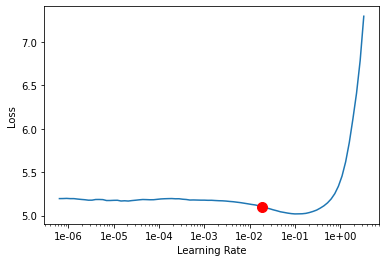

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(2, 1E-02,callbacks=[SaveModelCallback(learn, name="best_lm4")], moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.628883,4.266243,0.255569,01:00
1,4.093730,4.198333,0.262106,00:59


Better model found at epoch 0 with valid_loss value: 4.266242504119873.
Better model found at epoch 1 with valid_loss value: 4.198333263397217.


In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1, 1E-03,callbacks=[SaveModelCallback(learn, name="best_lm4")], moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.796269,4.158582,0.266747,01:00


Better model found at epoch 0 with valid_loss value: 4.158581733703613.


In [0]:
learn.load('best_lm4')
learn.save_encoder('ft_enc4')

## Classifier model training

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc4')
pass

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 1.74E-02


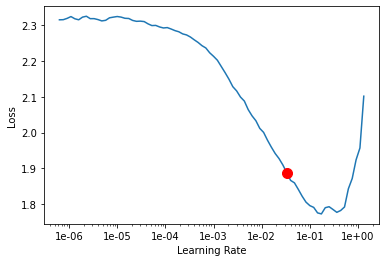

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
best_clf_lr = learn.recorder.min_grad_lr
best_clf_lr

0.03311311214825908

In [0]:
learn.fit_one_cycle(1, best_clf_lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.593442,1.560048,0.473333,01:05


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, best_clf_lr)


epoch,train_loss,valid_loss,accuracy,time
0,1.489604,1.459151,0.497778,01:03


In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 5.75E-03


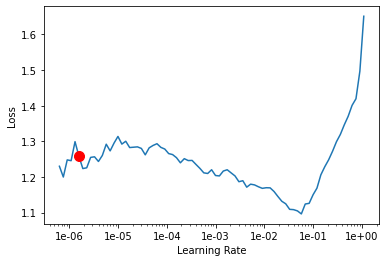

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(3, 2E-02,callbacks=[SaveModelCallback(learn, name="best_clf_4")])

epoch,train_loss,valid_loss,accuracy,time
0,1.225091,1.690183,0.453333,01:00
1,1.017299,1.431820,0.564444,01:01
2,0.696018,1.221634,0.611111,01:13


Better model found at epoch 0 with valid_loss value: 1.6901832818984985.
Better model found at epoch 1 with valid_loss value: 1.4318201541900635.
Better model found at epoch 2 with valid_loss value: 1.2216335535049438.


In [0]:
learn.load('./best_clf_4')
pass

In [0]:
learn.show_results()

text,target,prediction
xxbos xxup its xxup lock xxup on for xxmaj indian xxmaj real xxmaj estate \n \n * * * xxup lock – xxup on means ' xxmaj xxunk ' which refers to the removal of xxunk by making something clear . * * * \n \n xxmaj we never would ’ve imagined a day when 1 / 3rd of world ’s population would be in a lockdown .,Business/Finance,Science/Technology
"xxbos xxmaj what is this government doing wrong on economic xxunk another bank goes bust , i keep hearing that the government has screwed up the economy . i am looking for someone who can provide me specific instances of decisions that the government took / did not take , that have led to the current economic slowdown and the financial crisis . \n \n xxmaj is this still",Policy/Economy,Policy/Economy
xxbos xxmaj facial xxmaj recognition in xxmaj india : xxmaj part i # # \n \n https : / / preview.redd.it / xxunk \n \n # # xxmaj tl;dr \n \n xxup iff has been tracking various facial recognition technology ( xxup xxunk ) projects in different stages of development all over xxmaj india . xxmaj in the first part of this three part series on xxup,Policy/Economy,Non-Political
"xxbos xxmaj fuck all xxunk all religion . xxmaj fuck xxmaj xxunk , fuck xxmaj islam , fuck xxmaj christianity , fuck xxmaj xxunk . xxmaj fuck you all for believing in this made up bullshit called xxmaj religion . xxmaj you know what i think about your religions ? i think it is a waste of time , i think it is just another xxunk for childish adults who",Politics,Non-Political
"xxbos xxmaj under xxmaj modi , xxmaj india ’s xxmaj press xxmaj is xxmaj not xxmaj so xxmaj free xxmaj xxunk xxmaj the amount of damage xxup ani alone does is unimaginable . xxmaj suddenly seeing anti xxmaj modi posts being downvoted like crazy . xxmaj what 's happening ? > xxmaj as the government announced the crackdown in xxmaj kashmir , xxup xxunk xxmaj anand , the managing director",Politics,Politics


## Confusion Matrix

In [0]:
import sklearn.metrics

0.5976872719663238


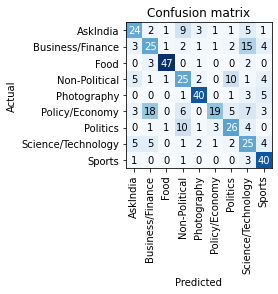

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
f1=sklearn.metrics.f1_score(y,np.argmax(preds,axis=1),average='weighted')
print (f1)
interp.plot_confusion_matrix()